In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets
train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
model = NeuMF(users_num,movies_num,16,[128,64,32])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)
test_loss = []
train_loss = []
for epoch in range(50):
    model.train()
    tr_loss=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    train_loss.append(np.mean(tr_loss))
    model.eval()
    predictions = []
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl) 
        test_loss.append(np.mean(t_loss))

Traininng 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.34it/s]


Traininng 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.62it/s]


Traininng 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.70it/s]


Traininng 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.96it/s]


Traininng 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.67it/s]


Traininng 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.03it/s]


Traininng 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.18it/s]


Traininng 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.29it/s]


Traininng 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.39it/s]


Traininng 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.33it/s]


Traininng 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.52it/s]


Traininng 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.32it/s]


Traininng 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.28it/s]


Traininng 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.52it/s]


Traininng 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.39it/s]


Traininng 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.35it/s]


Traininng 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.66it/s]


Traininng 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.23it/s]


Traininng 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.74it/s]


Traininng 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.02it/s]


Traininng 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.07it/s]


Traininng 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.85it/s]


Traininng 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.31it/s]


Traininng 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.23it/s]


Traininng 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.00it/s]


Traininng 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.37it/s]


Traininng 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.15it/s]


Traininng 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.06it/s]


Traininng 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.56it/s]


Traininng 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.26it/s]


Traininng 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.20it/s]


Traininng 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.53it/s]


Traininng 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.29it/s]


Traininng 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.26it/s]


Traininng 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.49it/s]


Traininng 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.39it/s]


Traininng 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.34it/s]


Traininng 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.63it/s]


Traininng 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.24it/s]


Traininng 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.11it/s]


Traininng 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.14it/s]


Traininng 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.25it/s]


Traininng 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.96it/s]


Traininng 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.19it/s]


Traininng 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.33it/s]


Traininng 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.49it/s]


Traininng 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.54it/s]


Traininng 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.35it/s]


Traininng 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.41it/s]


Traininng 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.76it/s]


### Plot results

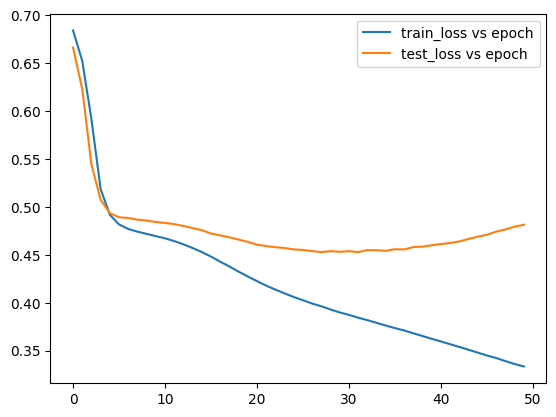

In [9]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)

In [18]:
def HR_at_n(R, R_hat, R_exclude, nu, ni, n=10):
    exclude_items_cnt = torch.tensor([torch.sum(R_exclude == user_id) for user_id in range(nu)])
    test_items_cnt = torch.tensor([torch.sum(R == user_id) for user_id in range(nu)])
    
    hr_total = 0
    for user_id in range(nu):
        min_end = min(n, ni - exclude_items_cnt[user_id])
        pred_items_for_user = torch.argsort(R_hat[R == user_id], descending=True).numpy()[:min_end]
        proper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user, R[R == user_id]))
        
        if test_items_cnt[user_id] > 0:
            hr_for_user = proper_itemscnt_for_user / min(n, test_items_cnt[user_id])
            hr_total += hr_for_user
    
    hr_total /= nu
    
    return hr_total

In [12]:
import numpy as np

# Zdefiniuj hiperparametry
lr = 0.001
mf_dim = 16
mlp_layer_sizes = [128, 64, 32]

# Inicjalizacja modelu, kryterium i optymalizatora
model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)

# Pętla treningowa
for epoch in range(10):  
    model.train()
    for (u, i, l) in train_dl:
        optimizer.zero_grad()
        yhat = model(u, i, sigmoid=True)
        l = l.unsqueeze(1)
        loss = criterion(yhat, l)
        loss.backward()
        optimizer.step()

# Generowanie rekomendacji
model.eval()
recommendations = {}
hit_count = 0
with torch.no_grad():
    for user_id in range(1, users_num):
        user = torch.tensor([user_id]*movies_num).long()
        item = torch.tensor(range(movies_num)).long()
        labels = torch.tensor([1 if item in ds_test[user_id] else 0 for item in range(movies_num)]).float()
        predictions = model(user, item, sigmoid=True).numpy()
        top_k = np.argsort(predictions)[::-1][:10]  # top 10 recommendations
        recommendations[user_id] = top_k
        hit_count += int(any(label in top_k for label in np.where(labels==1)[0]))

# Obliczanie HR@10
hr_at_10 = hit_count / (users_num-1)
print(f'HR@10: {hr_at_10}')


HR@10: 0.0


In [21]:
def train_model(ds_num, dim, sizes):
    ds_train = ML100kDataset(f'ml-100k/u{ds_num}.base', 2)
    ds_test = ML100kDataset(f'ml-100k/u{ds_num}.test', 2)
    train_dl = DataLoader(ds_train, batch_size=16*1024, shuffle=True)
    test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
    model = NeuMF(944, 1683, dim, sizes)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    test_loss = []
    train_loss = []

    for epoch in range(10):
        model.train()
        tr_loss = []
        for u, i, l in tqdm.tqdm(train_dl, leave=False, desc="Traininng " + str(epoch)):
            optimizer.zero_grad()
            yhat = model(u, i, sigmoid=True)
            loss = criterion(yhat, l.unsqueeze(1))
            loss.backward()
            optimizer.step()
            tr_loss.append(loss.item())

        train_loss.append(np.mean(tr_loss))
        model.eval()
        predictions = []
        with torch.no_grad():
            t_loss = []
            for u, i, l in test_dl:
                yhat = model(u, i, sigmoid=True)
                predictions.append(yhat)
                t_loss.append(criterion(yhat, l.unsqueeze(1)).item())

            test_loss.append(np.mean(t_loss))

    hr = HR_at_n(test_dl.dataset.users, torch.cat(predictions), train_dl.dataset.users, 944, 1683, 10)
    return hr

# Wykonanie treningu z różnymi kombinacjami hiperparametrów
results = []
for dim in [8, 12, 16]:
    print(dim)
    for sizes in [[128, 64], [64, 32, 16], [128, 64, 32]]:
        print(sizes)
        hr = []
        for fold in range(1, 6):
            hr.append(train_model(fold, dim, sizes))
        results.append([dim, sizes, np.mean(hr)])

print(results)

8
[128, 64]


[64, 32, 16]


[128, 64, 32]


12
[128, 64]


[64, 32, 16]


[128, 64, 32]


16
[128, 64]


[64, 32, 16]


[128, 64, 32]


[[8, [128, 64], 0.0], [8, [64, 32, 16], 0.0], [8, [128, 64, 32], 0.0], [12, [128, 64], 0.0], [12, [64, 32, 16], 0.0], [12, [128, 64, 32], 0.0], [16, [128, 64], 0.0], [16, [64, 32, 16], 0.0], [16, [128, 64, 32], 0.0]]


In [ ]:
#It seems that the results being consistently zero may indicate an issue in the data preparation or the 
#implementation of the HR@n calculation function. Given the random input values instead of actual 
#ratings, it's possible that the model is not able to make accurate predictions.
# Double-checking the data input process and ensuring that the 
#ratings are correctly assigned could potentially lead to more meaningful results.